<img src="HowToRun.png">

<img src="hybridMatrix.png">

In [1]:
%%javascript
OutputArea.prototype._should_scroll = function(){return false}

<IPython.core.display.Javascript object>

In [2]:
# Click triangle on the left to unfold the code  

import numpy as np
import csv
import pandas as pd
from bokeh.plotting import *
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper,ColorBar, TextAnnotation, layouts, NumeralTickFormatter
import scipy.io
from scipy.io import loadmat
import matplotlib as plt
import matplotlib.cm as cm
from subprocess import call
from bokeh.models.glyphs import Text
from bokeh.charts import Bar
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons, Layout, Button, Box, VBox, Label, HBox
import matplotlib.pyplot as pltt
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')



# Load statistical data in native Octave format (.mat) 
# Processing was performed on MATLAB R2015b using spmrt toolbox (https://github.com/CPernet/spmrt)

mat = loadmat('corMatrices.mat', struct_as_record=False)
strBin = mat['binMatrices']
strMat = mat['corMatrices']

mat = loadmat('histoConcordance.mat', struct_as_record=False)
strVec = mat['concordVec'];

mat = loadmat('histoCorrelation.mat', struct_as_record=False)
corrVec = mat['correlationVec'];

spmrtStruct = namedtuple("spmrtStruct", "rP CIlow CIup")
corStruct = namedtuple("corStruct", "whole wm gm")
mainStruct = namedtuple("mainStruct","NumMat BinMat")
concordStruct = namedtuple("mainStruct","cVec CIlow CIup")



wholeMat = spmrtStruct(np.array(strMat[0,0].whole[0,0].rP),np.array(strMat[0,0].whole[0,0].CIlow),np.array(strMat[0,0].whole[0,0].CIup))
wmMat = spmrtStruct(np.array(strMat[0,0].wm[0,0].rP),np.array(strMat[0,0].wm[0,0].CIlow),np.array(strMat[0,0].wm[0,0].CIup))
gmMat = spmrtStruct(np.array(strMat[0,0].gm[0,0].rP),np.array(strMat[0,0].gm[0,0].CIlow),np.array(strMat[0,0].gm[0,0].CIup))

corMat = corStruct(wholeMat,wmMat,gmMat);
corBin = corStruct(np.array(strBin[0,0].whole[0,0].bin),np.array(strBin[0,0].wm[0,0].bin),np.array(strBin[0,0].gm[0,0].bin));

strData = mainStruct(corMat,corBin);

wholeVec = spmrtStruct(np.array(strVec[0,0].whole[0,0].cVec),np.array(strVec[0,0].whole[0,0].lwCI),np.array(strVec[0,0].whole[0,0].upCI))
wmVec = spmrtStruct(np.array(strVec[0,0].wm[0,0].cVec),np.array(strVec[0,0].wm[0,0].lwCI),np.array(strVec[0,0].wm[0,0].upCI))
gmVec = spmrtStruct(np.array(strVec[0,0].gm[0,0].cVec),np.array(strVec[0,0].gm[0,0].lwCI),np.array(strVec[0,0].gm[0,0].upCI))


strDatVec = corStruct(wholeVec,wmVec,gmVec);

wholeVec = spmrtStruct(np.array(corrVec[0,0].whole[0,0].cVec),np.array(corrVec[0,0].whole[0,0].lwCI),np.array(corrVec[0,0].whole[0,0].upCI))
wmVec = spmrtStruct(np.array(corrVec[0,0].wm[0,0].cVec),np.array(corrVec[0,0].wm[0,0].lwCI),np.array(corrVec[0,0].wm[0,0].upCI))
gmVec = spmrtStruct(np.array(corrVec[0,0].gm[0,0].cVec),np.array(corrVec[0,0].gm[0,0].lwCI),np.array(corrVec[0,0].gm[0,0].upCI))

strDatVec2 = corStruct(wholeVec,wmVec,gmVec);


def bokehCorPlotMat(nodeFile1,nodeFile2,strData,maskName,plotTitle):
    
    nodes = pd.read_csv(nodeFile1)
    nodes['name'] = [str(x) for x in nodes['name']]
    names1 = list(nodes['name'])
    
    nodes = pd.read_csv(nodeFile2)
    nodes['name'] = [str(x) for x in nodes['name']]
    names2 = list(nodes['name'])
    
    
    curData = strData.NumMat
    
        
    if (maskName is 'whole'):
        rP = np.transpose(curData.whole.rP)
        CIlow =  np.transpose(curData.whole.CIlow)
        CIup =  np.transpose(curData.whole.CIup)
    elif (maskName is 'wm'):
        rP = np.transpose(curData.wm.rP)
        CIlow =  np.transpose(curData.wm.CIlow)
        CIup =  np.transpose(curData.wm.CIup)
    elif (maskName is 'gm'):
        rP = np.transpose(curData.gm.rP)
        CIlow =  np.transpose(curData.gm.CIlow)
        CIup =  np.transpose(curData.gm.CIup)
        
    shp = np.shape(rP)
    sz = shp[1]
   
    n1 = []
    n2 = []
    color = []
    weight = []
    alpha = []
    desc = []
    lowCI = []
    upCI = []

    for node1 in range(0,sz):
        for node2 in range(0,sz):
            n1.append(names1[node1])
            n2.append(names2[node2])
            value = rP[node1][node2]
            weight.append(round(value,3))
            value = CIlow[node1][node2]
            lowCI.append(round(value,3))
            value = CIup[node1][node2]
            upCI.append(round(value,3))
            
            if ((node1 == node2)):
                desc.append('Index is pC for scan-rescan')
        
                
            if ((node1 < node2)):
                desc.append('Index is dif. between pair pCs')
          
                
            if ((node1 > node2)):
                desc.append('Index is pC between pairs')
       
                
            
            alpha.append(0.8)

    source = ColumnDataSource(data=dict(
            xname=n1,
            yname=n2,
            CIlow = CIlow.flatten(),
            CIup  = CIup.flatten(),
            alpha=alpha,
            weight = weight,
            rP=rP.flatten(),
            desc = desc,
            upCI = upCI,
            lowCI = lowCI,
            )
        )

    colormap =cm.get_cmap("rainbow") 
    bokehpalette = [plt.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]

    color_mapper = LinearColorMapper(palette=bokehpalette, low=min(rP.flatten()), high=max(rP.flatten()))
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(2,0))   

    p = figure(title=plotTitle,
           x_axis_location="above", tools="hover,save",
           x_range=list((names1)), y_range=list(reversed(names1)))
    

    p.title.align = 'center'
    p.title.text_font_style = 'bold'
    p.title_location = 'below'
    
    
    p.plot_width = 450
    p.plot_height = 430
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "10pt"
    p.axis.axis_label_text_color =  None
    p.axis.major_label_standoff = 1
    p.xaxis.major_label_orientation = np.pi/5
    
    p.add_layout(color_bar, 'right')
    p.rect('xname', 'yname', 0.9, 0.9, source=source, alpha='alpha', line_color=None,
    hover_line_color='black',color={'field': 'rP', 'transform': color_mapper})

    p.select_one(HoverTool).tooltips = [
    ('Pair', '@yname, @xname'),
    ('Index', '@weight{1.111}'),
    ('Conf. Int. ', '[@lowCI{1.111} to @upCI{1.111}]'),
    ('Message', '@desc'),
    ]
    
    p.toolbar.logo = None
    p.toolbar_location = None
    text_props = {"source": source, "text_align": "center", "text_baseline": "middle"}
    r = p.text(x='xname',y='yname',text="weight", **text_props)

    #output_file("correlation.html", title="Correlation Matix")
    return p

    
    
    
    
def bokehCorPlotBin(nodeFile1,nodeFile2,strData,maskName,plotTitle):

    nodes = pd.read_csv(nodeFile1)
    nodes['name'] = [str(x) for x in nodes['name']]
    names1 = list(nodes['name'])
    
    nodes = pd.read_csv(nodeFile2)
    nodes['name'] = [str(x) for x in nodes['name']]
    names2 = list(nodes['name'])
    
    
    curData = strData.BinMat
    
        
    if (maskName is 'whole'):
        rP = np.transpose(curData.whole)
       
    elif (maskName is 'wm'):
        rP = np.transpose(curData.wm)
     
    elif (maskName is 'gm'):
        rP = np.transpose(curData.gm)

        
    shp = np.shape(rP)
    sz = shp[1]
 
    n1 = []
    n2 = []
    color = []
    weight = []
    alpha = []
    desc =[]

    for node1 in range(0,sz):
        for node2 in range(0,sz):
            n1.append(names1[node1])
            n2.append(names2[node2])
            if rP[node1][node2] == 1:
                weight.append('Significant')
            else:
                weight.append('N/S')
            
            if ((node1 == node2) and (rP[node1][node2] == 1)):
                desc.append('Scan-rescan is reliable')
            elif ((node1 == node2) and (rP[node1][node2] == 0)):
                desc.append('Scan-rescan is not Reliable')
                
            if ((node1 < node2) and (rP[node1][node2] == 1)):
                desc.append('Pairs are different')
            elif ((node1 < node2) and (rP[node1][node2] == 0)):    
                desc.append('Pairs are not  different')
                
            if ((node1 > node2) and (rP[node1][node2] == 1)):
                desc.append('Pairs are similar')
            elif ((node1 > node2) and (rP[node1][node2] == 0)):   
                desc.append('Pairs are not similar')
                
                
                
            alpha.append(0.8)
    
    source = ColumnDataSource(data=dict(
            xname=n1,
            yname=n2,
            alpha=alpha,
            weight = weight,
            desc = desc,
            rP=rP.flatten()
            )
        )

    colormap =cm.get_cmap("RdYlGn") 
    bokehpalette = [plt.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]

    color_mapper = LinearColorMapper(palette=bokehpalette, low=0, high=1)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(2,0))   

    p = figure(title=plotTitle,
           x_axis_location="above", tools="hover,save",
           x_range=list((names1)), y_range=list(reversed(names1)))
    
    p.title.align = 'center'
    p.title.text_font_style = 'bold'
    p.title_location = 'below'

    p.plot_width = 450
    p.plot_height = 430
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "10pt"
    p.axis.axis_label_text_color =  None
    p.axis.major_label_standoff = 1
    p.xaxis.major_label_orientation = np.pi/5
    
    p.add_layout(color_bar, 'right')
    p.rect('xname', 'yname', 0.9, 0.9, source=source, alpha='alpha', line_color=None,
    hover_line_color='black',color={'field': 'rP', 'transform': color_mapper})

    p.select_one(HoverTool).tooltips = [
    ('Pair', '@yname, @xname'),
    ("Index", "@rP"),
    ("Stat", "@desc"), 
    ]
    
    p.toolbar.logo = None
    p.toolbar_location = None
    #text_props = {"source": source, "text_align": "center", "text_baseline": "middle"}
    #r = p.text(x='xname',y='yname',text="weight", **text_props)

    #output_file("correlation.html", title="Correlation Matix")
    return p
def bokehConVecPlot(nodeFile1,strDatVec,maskName,plotTitle):

    nodes = pd.read_csv(nodeFile1)
    nodes['name'] = [str(x) for x in nodes['name']]
    names1 = list(nodes['name'])
    
    if (maskName is 'whole'):
        rP = np.squeeze(strDatVec.whole.rP)
        CIlow = np.squeeze(strDatVec.whole.CIlow)
        CIup = np.squeeze(strDatVec.whole.CIup)
    elif (maskName is 'wm'):
        rP = np.squeeze(strDatVec.wm.rP)
        CIlow = np.squeeze(strDatVec.wm.CIlow)
        CIup = np.squeeze(strDatVec.wm.CIup)
     
    elif (maskName is 'gm'):
        rP = np.squeeze(strDatVec.gm.rP)
        CIlow = np.squeeze(strDatVec.gm.CIlow)
        CIup = np.squeeze(strDatVec.gm.CIup)
    
    desc = []    
    for node1 in range(0,4):
        
            
            if (CIlow[node1])<0 and (CIup[node1])>0:
                desc.append('N/S');
            else:
                desc.append('Significant');
            
    p = figure(x_range=names1, plot_height=150,plot_width=300, title=plotTitle)

    source = ColumnDataSource(data=dict(
            desc = desc,
            CIlow = CIlow,
            CIup  = CIup,
            rP=rP,
            methods = names1,
            )
        )

    hover = HoverTool(
        tooltips=[
            ("rP", "@rP{1.111}"),
            ("CI", "[@CIlow{1.111} to @CIup{1.111}]"),
            ("Method", "@methods"),
            ("desc","@desc"),
        ]
    )

    p.add_tools(hover)
    
    p.vbar(x=names1, top=rP, width=0.5,source=source,fill_color="darkgray")
    p.yaxis.formatter=NumeralTickFormatter(format="0.000")
    p.y_range.start = 0
    p.toolbar.logo = None
    p.toolbar_location = None
    return(p)

output_notebook()
#  Prepare all bokeh ouputs in advance to enable faster interaction 

sectionROI = widgets.ToggleButtons(options=['Whole_SC','Gray_Matter','White_Matter'],description='Please select ROI:',button_style='info')
display(sectionROI)

p1 = bokehCorPlotMat('MethodNames.csv','MethodNames.csv',strData,'gm','Hybrid Matrix: Gray Matter')
p2 = bokehCorPlotBin('MethodNames.csv','MethodNames.csv',strData,'gm','Significance Matrix: Gray Matter')
gmShow = layouts.Row(p1,p2) 

p3 = bokehCorPlotMat('MethodNames.csv','MethodNames.csv',strData,'wm','Hybrid Matrix: White Matter')
p4 = bokehCorPlotBin('MethodNames.csv','MethodNames.csv',strData,'wm','Significance Matrix: White Matter')
wmShow = layouts.Row(p3,p4) 

p5 = bokehCorPlotMat('MethodNames.csv','MethodNames.csv',strData,'whole','Hybrid Matrix: Whole SC')
p6 = bokehCorPlotBin('MethodNames.csv','MethodNames.csv',strData,'whole','Significance Matrix: Whole SC')
wholeShow = layouts.Row(p5,p6) 

# Concordance plots 
p7 = bokehConVecPlot('MethodNames.csv',strDatVec,'whole','Concordance Whole SC')
p8 = bokehConVecPlot('MethodNames.csv',strDatVec,'gm','Concordance Gray Matter')
p9 = bokehConVecPlot('MethodNames.csv',strDatVec,'wm','Concordance White Matter')
concordances = layouts.Row(p7,p8,p9)
show(wholeShow) # Let this pop up by default before user clicks on anything 
show(concordances) # Show concordances with histo 


p10 = bokehConVecPlot('MethodNames.csv',strDatVec2,'whole','Correlation Whole SC')
p11 = bokehConVecPlot('MethodNames.csv',strDatVec2,'gm','Correlation Gray Matter')
p12 = bokehConVecPlot('MethodNames.csv',strDatVec2,'wm','Correlation White Matter')
correlations = layouts.Row(p10,p11,p12)
show(correlations) # Show correlations with histo 
    




def clicked(b):
    clear_output()
    if (sectionROI.value is 'Gray_Matter'):
        show(gmShow)
    elif(sectionROI.value is 'White_Matter'):
        show(wmShow)
    elif(sectionROI.value is 'Whole_SC'):
        show(wholeShow)
    show(concordances)
    show(correlations)
    
sectionROI.observe(clicked)

Loading BokehJS ...

<img src="shifBanner.png">

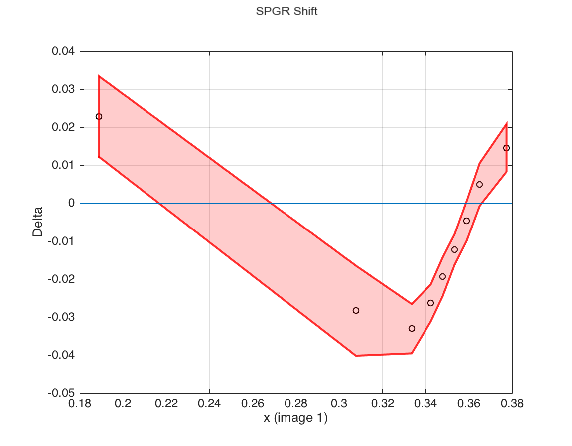

In [3]:
# Click triangle on the left to unfold the code
sectionMet = widgets.ToggleButtons(options=['SPGR','FSIR','MWF','MTV'],description='Please select Method:',button_style='info');
display(sectionMet)



mat = loadmat('spgrShifts.mat')
ttl = 'SPGR vs Histology deciles'
img1 = np.array(mat['spgrShifts'])
graph = np.array(mat['graph'])
pltt.figure(figsize=(10,10))
pltt.imshow(graph)
pltt.title('SPGR Shift')
pltt.grid(False)
pltt.xticks([])
pltt.yticks([])
pltt.show()
        
def clicked(b):
    clear_output()
    global img1
    global graph
    global ttl
    
    if (sectionMet.value is 'MWF'):
        mat = loadmat('mwfShifts.mat')
        ttl = 'MWF vs Histology deciles'
        img1 = np.array(mat['mwfShifts'])
        graph = np.array(mat['mwfGraph'])
        pltt.figure(figsize=(10,10))
        pltt.imshow(graph)
        pltt.title('MWF Shift')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
        
    elif (sectionMet.value is 'SPGR'):
        mat = loadmat('spgrShifts.mat')
        ttl = 'SPGR vs Histology deciles'
        img1 = np.array(mat['spgrShifts'])
        graph = np.array(mat['graph'])
        pltt.figure(figsize=(10,10))
        pltt.imshow(graph)
        pltt.title('SPGR Shift')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()

    elif (sectionMet.value is 'FSIR'):
        mat = loadmat('fsirShifts.mat')
        img1 = np.array(mat['fsirShifts'])
        graph = np.array(mat['graph'])
        ttl = 'FSIR vs Histology deciles'
        pltt.figure(figsize=(10,10))
        pltt.imshow(graph)
        pltt.title('FSIR Shift')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    
    elif (sectionMet.value is 'MTV'):
        mat = loadmat('mtvShifts.mat')
        img1 = np.array(mat['mtvShifts'])
        graph = np.array(mat['graph'])
        ttl = 'MTV vs Histology deciles'
        pltt.figure(figsize=(10,10))
        pltt.imshow(graph)
        pltt.title('MTV Shift')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
        return b


    
    
def f(x):
    global img1
    global ttl
    
    pltt.figure(figsize=(5,5))
    pltt.imshow(img1[:,:,:,x-1])
    pltt.title(ttl)
    pltt.grid(False)
    pltt.xticks([])
    pltt.yticks([])
    pltt.show()
    
    return x



interact(f,x=widgets.IntSlider(min=1,max=10,step=1,value=1))


sectionMet.observe(clicked)


<img src="subshift.png">

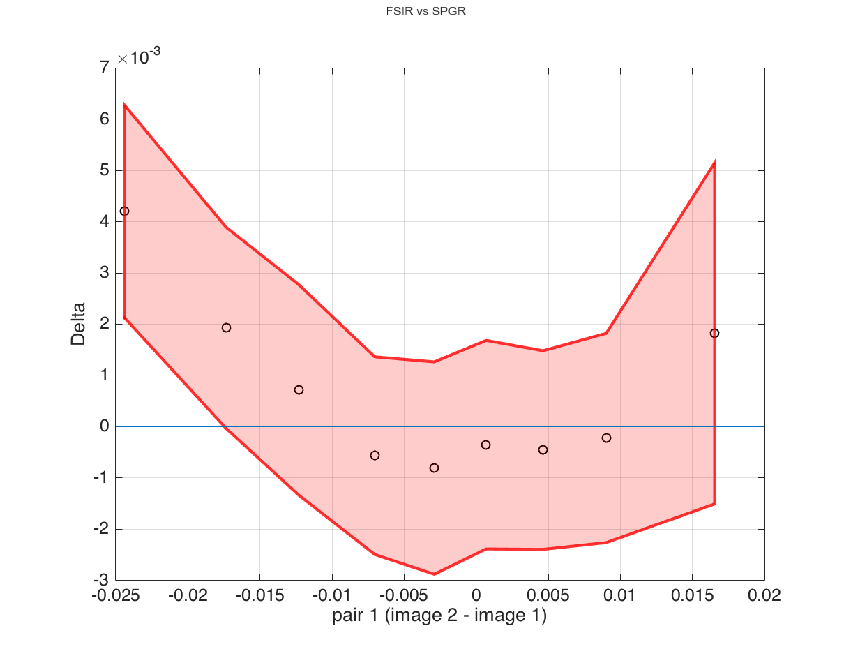

In [4]:
# Click triangle on the left to unfold the code
sectionMet = widgets.ToggleButtons(options=['FSIR_SPGR','MTV_SPGR','MTV_FSIR','MWF_SPGR','MWF_FSIR','MWF_MTV'],button_style='info');


mat= loadmat('shiftSubs.mat')
subscont = mat['shiftsubsAll']
subscont = np.array(subscont)

box_layout1 = Layout(display='flex',
                    flex_flow='cloumn',
                    align_items='stretch',
                    
                    width='50%',
                    margin='10px'
                    )

box1 = Box(children=[sectionMet], layout=box_layout1)
display(VBox([Label('SELECT'), box1]))
pltt.figure(figsize=(15,15))
pltt.imshow(subscont[:,:,:,0])
pltt.title('FSIR vs SPGR')
pltt.grid(False)
pltt.xticks([])
pltt.yticks([])
pltt.show()


def clicked(b):
    clear_output()
    if (sectionMet.value is 'FSIR_SPGR'):
              
        pltt.figure(figsize=(15,15))
        pltt.imshow(subscont[:,:,:,0])
        pltt.title('FSIR vs SPGR')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    elif(sectionMet.value is 'MTV_SPGR'):
        pltt.figure(figsize=(15,15))
        pltt.imshow(subscont[:,:,:,1])
        pltt.title('MTV vs SPGR')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    elif(sectionMet.value is 'MTV_FSIR'):
        pltt.figure(figsize=(15,15))
        pltt.imshow(subscont[:,:,:,2])
        pltt.title('MTV vs FSIR')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    elif(sectionMet.value is 'MWF_SPGR'):
        pltt.figure(figsize=(15,15))
        pltt.imshow(subscont[:,:,:,3])
        pltt.title('MWF vs SPGR')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    elif(sectionMet.value is 'MWF_FSIR'):
        pltt.figure(figsize=(15,15))
        pltt.imshow(subscont[:,:,:,4])
        pltt.title('MWF vs FSIR')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    elif(sectionMet.value is 'MWF_MTV'):
        pltt.figure(figsize=(15,15))
        pltt.imshow(subscont[:,:,:,5])
        pltt.title('MWF vs MTV')
        pltt.grid(False)
        pltt.xticks([])
        pltt.yticks([])
        pltt.show()
    
sectionMet.observe(clicked)





<img src="copyright_neuropoly.png">

<img src="author.png">